#### Script that evalueates the synthetic profiles for the 4 types of profiles present

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.metrics import mean_squared_error
import pickle
import scipy.stats
from scipy.stats import *

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
from Gauss_fit_functions import extractFIT, extractToPs , gauss, straight_line
from synthetic_profiles_functions import *

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


In [2]:
X = genX([1994,2014],drop_0 = True)

dropping all zero rows


In [3]:
profileIDs = pd.read_pickle('ProfileIDs.pkl') # Read pickle file

## High Season Weekdays a.k.a. Winter Weekdays


In [4]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends

# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
df_winter['day_names'] = df_winter.date.dt.day_name()
df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekdays), 'weekday')
df_winter.drop(['day_names'], axis = 1, inplace = True)
df_winter_weekdays  = df_winter[df_winter['daytype'] == 'weekday'] # Create dataframe with only weekdays
df_winter_weekdays.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_winter_weekdays =  df_winter_weekdays[df_winter_weekdays.ProfileID.isin(profileIDs)]
# df_winter_weekdays.set_index(['ProfileID','date'], inplace=True)

# High Season Weekends a.k.a. Winter Weekends

In [5]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekends = ['Sunday', 'Saturday']
df_winter['day_names'] = df_winter.date.dt.day_name()
df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekends), 'weekend')
df_winter.drop(['day_names'], axis = 1, inplace = True)
df_winter_weekend  = df_winter[df_winter['daytype'] == 'weekend'] # Create dataframe with only weekdays
df_winter_weekend.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_winter_weekend = df_winter_weekend[df_winter_weekend.ProfileID.isin(profileIDs)]

## Low Season Weekday a.k.a. Not Winter Weekday

In [6]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_summer = df[df['season'] == 'summer'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
weekends = ['Sunday', 'Saturday']
df_summer['day_names'] = df_summer.date.dt.day_name()
df_summer['daytype'] = df_summer.day_names.where(~df_summer.day_names.isin(weekdays), 'weekday')
df_summer.drop(['day_names'], axis = 1, inplace = True)
df_summer_weekday  = df_summer[df_summer['daytype'] == 'weekday'] # Create dataframe with only weekdays
df_summer_weekday.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_summer_weekday = df_summer_weekday[df_summer_weekday.ProfileID.isin(profileIDs)]

## Low Season Weekend a.k.a. Not Winter Weekend

In [7]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_summer = df[df['season'] == 'summer'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
weekends = ['Sunday', 'Saturday']
df_summer['day_names'] = df_summer.date.dt.day_name()
df_summer['daytype'] = df_summer.day_names.where(~df_summer.day_names.isin(weekends), 'weekend')
df_summer.drop(['day_names'], axis = 1, inplace = True)
df_summer_weekends  = df_summer[df_summer['daytype'] == 'weekend'] # Create dataframe with only weekdays
df_summer_weekends.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_summer_weekends = df_summer_weekends[df_summer_weekends.ProfileID.isin(profileIDs)]

# Load The Gauss Fit Features

## High Season Weekdays

In [8]:
season = "Low_season_weekends" #HighSeason_weekdays, Low_season_weekdays, Low_season_weekends, High_season_weekends


if season == "Low_season_weekdays":
    cleaned_df = df_summer_weekday.copy()

elif season == "Low_season_weekends":
    cleaned_df = df_summer_weekends.copy()

elif season == "HighSeason_weekdays":
    cleaned_df = df_winter_weekdays.copy()
    
elif season == "High_season_weekends":
    cleaned_df = df_winter_weekend.copy()


gaus_fit_features = pd.read_csv('FitFeatures_' + season + '.csv')
gauss_profileIds = gaus_fit_features['ProfileID'].unique()
cleaned_df_profile_ids = cleaned_df['ProfileID'].unique()

profileIDs_2 = np.intersect1d(gauss_profileIds, cleaned_df_profile_ids)

cleaned_df = cleaned_df.loc[cleaned_df.ProfileID.isin(profileIDs_2),:]
gauss_fit_features = gaus_fit_features.loc[gaus_fit_features.ProfileID.isin(profileIDs_2),:]

In [9]:
gauss_fit_features

,ProfileID,H_offset,sigma1,sigma2,mu1,A1,sigma3,sigma4,mu2,A2
0,1,1.483108,2.051282,1.142857,6,0.319032,1.612903,1.568627,20,1.272635
1,3,3.346581,2.051282,1.355932,8,2.259837,3.157895,2.424242,20,3.828025
2,5,1.892798,2.666667,0.377358,3,0.300637,3.428571,1.538462,21,5.412989
3,6,1.571732,1.538462,2.352941,9,4.653599,0.800000,1.355932,19,3.995477
4,10,1.392301,1.500000,2.051282,7,3.495439,4.000000,3.333333,17,3.458126
...,...,...,...,...,...,...,...,...,...,...
9536,12029045,6.826667,0.714286,2.222222,7,11.983333,2.222222,2.400000,17,11.620000
9537,12029049,0.160000,1.714286,1.538462,3,0.223333,1.176471,2.051282,19,1.760000
9538,12029058,9.746667,2.909091,4.210526,10,11.733333,1.481481,2.448980,18,19.726667
9539,12029062,3.953333,1.728395,2.307692,9,5.640000,2.068966,1.538462,17,6.416667


## Extract the Amplitudes from the measured profiles

In [11]:
# # Create cols
# cols = ['ProfileID','A1','A2','mu1','mu2']

# # Create dummy variables
# mu1 = 0
# A1 = 0 
# mu2 = 0
# A2 = 0

# data=[['DROP_ROW',A1,A2,mu1,mu2]]

# amplitudes_df = pd.DataFrame(data, columns=cols)

# profileIDs_3 = gauss_fit_features['ProfileID'].unique()

# for id in tqdm(profileIDs_3):
#     for index in cleaned_df[cleaned_df['ProfileID'] == id].index:
#         A1, A2, mu1, mu2, check = extractToPs(cleaned_df[cleaned_df['ProfileID'] == id].loc[index])
#         if check == False:
#             continue
        
#         data=[[id,A1,A2,mu1,mu2]]
#         temp_df = pd.DataFrame(data, columns=cols)
#         # temp_df.set_index(['ProfileID'])
#         amplitudes_df = amplitudes_df.append(temp_df)
    
# amplitudes_df = amplitudes_df.set_index(['ProfileID'])
# temporary = amplitudes_df.copy()
# temporary.drop(['DROP_ROW'],axis = 0, inplace = True)

# Save all the peak values of the measured profiles

In [10]:
# temporary.to_csv("Low_Season_weekend_amplitudes.csv")
temporary = pd.read_csv("Low_Season_weekend_amplitudes.csv", index_col = ['ProfileID'])

In [11]:
def standard_deviation(my_list):
    #calculate population standard deviation of list 
    return (sum((x-(sum(my_list) / len(my_list)))**2 for x in my_list) / len(my_list))**0.5

In [14]:
temporary

,A1,A2,mu1,mu2
ProfileID,,,,
1,2.500000,5.508333,1,22
1,4.508333,2.325000,10,20
1,3.358333,12.291667,10,20
1,2.800000,1.333333,5,15
1,2.900000,1.283333,5,19
...,...,...,...,...
12029066,32.183334,48.149999,9,18
12029066,38.866667,34.383334,9,17
12029066,32.083333,38.483334,9,20


In [12]:
daily_consumption = pd.DataFrame()

daily_consumption['Daily_Consumption'] = cleaned_df.set_index(["ProfileID"]).sum(axis = 1)

std_deviation_df = pd.DataFrame(index = temporary.index.unique())

for id in tqdm(temporary.index.unique()):
    try:
        std_deviation_df.loc[id,'A1_std'] = standard_deviation(temporary.loc[id]['A1'])
        std_deviation_df.loc[id,'A2_std'] = standard_deviation(temporary.loc[id]['A2'])
        std_deviation_df.loc[id,'mu1_std'] = standard_deviation(temporary.loc[id]['mu1'])
        std_deviation_df.loc[id,'mu2_std'] = standard_deviation(temporary.loc[id]['mu2'])
        std_deviation_df.loc[id,'DC_std'] = standard_deviation(daily_consumption.loc[id]['Daily_Consumption'])
    except TypeError:
        print('TypeError')
        continue

  0%|          | 0/9539 [00:00<?, ?it/s]

TypeError
TypeError
TypeError
TypeError


In [13]:
gauss_fit_features.set_index(['ProfileID'], inplace = True)
combined_df = pd.merge(gauss_fit_features,std_deviation_df, left_index = True, right_index = True)
combined_df = combined_df.dropna()

## Loop that extracts the distributions fitted to user profiles measured peaks

In [17]:
# warnings.filterwarnings('ignore')
# profiles_ids = combined_df.index.unique().values

# cols = pd.MultiIndex.from_tuples([#("ProfileID",''),
#                                 ('A1', 'Distribution'),
#                                  ("A1", "chi_square"), 
#                                   ("A1", "params"), 
#                                   ("A2", "Distribution"),
#                                   ("A2", "chi_square"),
#                                   ("A2", "params") 
#                                   #, ('t1', 'Distribution'),
#                                   # ("t1", "chi_square"), 
#                                   # ("t1", "params"), 
#                                   # ("t2", "Distribution"),
#                                   # ("t2", "chi_square"),
#                                   # ("t2", "params"),
#                                 ])
# distributions_df = pd.DataFrame(index = profiles_ids,columns = cols)
# results = []
# for id in tqdm(profiles_ids):
#     # Extract the best distribution fitted
#     try:
#       results1 = fit_distribution(temporary.loc[id],'A1',0.99,0.01)
#       results2 = fit_distribution(temporary.loc[id],'A2',0.99,0.01)
#       # results3 = fit_distribution(temporary.loc[id],'mu1',0.99,0.01)
#       # results4 = fit_distribution(temporary.loc[id],'mu2',0.99,0.01)

#       results = [results1.values[0],results1.values[1],results1.values[2], results2.values[0],results2.values[1],results2.values[2]]
#                 # ,results3.values[0],results3.values[1],results3.values[2], results4.values[0],results4.values[1],results4.values[2]]

#       distributions_df.loc[id] = results
#     except Exception:
#       continue

# Save the file with the distributions information

In [14]:
# distributions_df.to_csv("Low_Season_Weekend_Distributions.csv")
distributions_df = pd.read_csv("Low_Season_Weekend_Distributions.csv", header = [0,1], index_col=0).dropna()

In [26]:
distributions_df

A1             \
         Distribution chi_square   
1            invgauss        4.0   
3            invgauss        1.0   
5            invgauss        3.0   
6               gamma        2.0   
10            lognorm        6.0   
...               ...        ...   
12029045     invgauss        1.0   
12029049     invgauss        6.0   
12029058     invgauss        1.0   
12029062     invgauss        1.0   
12029066     invgauss        2.0   

                                                                      A2  \
                                                     params Distribution   
1         (0.412149362098692, 0.7672642342392823, 6.3310...      lognorm   
3         (0.10601463521376699, -5.428647753199034, 155....     invgauss   
5         (0.028902268665080534, -8.983980988078287, 581...     invgauss   
6         (3.91601398225187, 0.6374753072580079, 1.94835...        gamma   
10        (0.08838726726245646, -14.530768408856385, 21....     invgauss   
...                                                     ...          ...   
12029045  (0.5036192777398238, 10.042275833362009, 14.92...  weibull_min   
12029049  (0.019835723826762394, 0.052216847902209956, 2...        gamma   
12029058  (0.017748287596798973, 7.441778066470324, 732....     invgauss   
12029062  (0.013815251954763491, -4.842573673781709, 104...     invgauss   
12029066  (0.012148926801526419, 23.289814785604477, 695...     invgauss   

                                                                        
         chi_square                                             params  
1              12.0  (1.6601685592998536, 1.1296004274413165, 1.414...  
3               3.0  (0.027023516917517858, -21.331194370712886, 12...  
5               5.0  (0.017627164942419005, -8.72341845732883, 1163...  
6               3.0  (1.9104892806346223, 2.7277778425174795, 2.913...  
10              2.0  (0.06854040263502306, -0.5076299732074347, 121...  
...             ...                                                ...  
12029045        1.0  (0.25831916122718857, 15.983333388964335, 3.30...  
12029049        2.0  (0.3950138298319146, 1.0333333536982534, 0.672...  
12029058        1.0  (0.026196088663546835, 25.462401275993216, 99....  
12029062        1.0  (0.03164499048398481, 2.9131514940027596, 282....  
12029066        1.0  (0.017050232559842914, 17.49253239797948, 1223...  

[9478 rows x 6 columns]

# Loop that generates the synthetic peaks from the fitted distributions

In [46]:
level_0 = distributions_df.columns.get_level_values(0).unique()
inv_data_df = pd.DataFrame()
temp_df_inv = pd.DataFrame()
for houseID in tqdm(distributions_df.index):
    for column in level_0:

        distributions = distributions_df[column].loc[houseID]['Distribution']
        parameters = distributions_df[column].loc[houseID]['params']
        print(parameters)
        parameters = eval(parameters)
        loc = combined_df.loc[houseID][column] + combined_df.loc[houseID]['H_offset']
        scale = combined_df.loc[houseID][column + '_std']  
        # loc = parameters[-2]
        # scale = parameters[-1]
        size = len(cleaned_df[cleaned_df['ProfileID'] == houseID])

        if distributions == 'invgauss':
            print('invgauss')
            data_points = invgauss.rvs(parameters[0],loc = loc,scale = scale,size = size)
        elif distributions == 'weibull_min':
            print('weibull_min')
            data_points = weibull_min.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'weibull_max':
            print('weibull_max')
            print(f'loc = {loc}, scale = {scale}')
            data_points = weibull_max.rvs(parameters[0], loc = loc, scale = scale, size = size)
            # data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 60)
        elif distributions == 'beta':
            print('beta')
            data_points = beta.rvs(parameters[0], parameters[1], loc = loc,scale = scale, size = size)
            # data_points = beta.rvs(parameters[0], parameters[1], parameters[2],parameters[3], size = 60)
        elif distributions == 'norm':
            print('norm')
            data_points = norm.rvs(parameters[0], parameters[1], size = size)
        elif distributions == 'triang':
            print('triang')
            data_points = triang.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'pearson3':
            print('pearson3')
            data_points = pearson3.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'lognorm':
            print('lognorm')
            data_points = lognorm.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'uniform':
            print('uniform')
            data_points = uniform.rvs(loc = loc,scale = scale, size = size)
        elif distributions == 'expon':
            print('expon')
            data_points = expon.rvs(loc = loc,scale = scale, size = size)
        elif distributions == 'gamma':
            print('gamma')
            data_points = gamma.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'alpha':
            print('alpha')
            data_points = alpha.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'arcsine':
            print('arcsine')
            data_points = arcsine.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'cauchy':
            print('cauchy')
            data_points = cauchy.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'dweibull':
            print('dweibull')
            data_points = dweibull.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'exponnorm':
            print('exponnorm')
            data_points = exponnorm.rvs(K=1.5, loc=loc, scale = scale,size=size)
        elif distributions == 'halflogistic':
            print('halflogistic')
            data_points = halflogistic.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'logistic':
            print('logistic')
            data_points = logistic.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'loggamma':
            print('loggamma')
            data_points = loggamma.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'powerlaw':
            print('powerlaw')
            data_points = powerlaw.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'powernorm':
            print('powernorm')
            data_points = powernorm.rvs(parameters[0], loc=loc, scale = scale,size=size)
        

        # print(column)
        # inverse_data_points = inverse_StandardScalar(data_points,temporary.loc[id],column,0.99,0.01)
        temp_df_inv['ProfileID'] = houseID
        temp_df_inv[column] = data_points#inverse_data_points
        
    inv_data_df = inv_data_df.append(temp_df_inv)
    temp_df_inv = pd.DataFrame()
        # if column == 'A1':
        #     data_pointA1 = data_points#inverse_data_points
        # elif column == 'A2':
        #     data_pointsA2 = data_points#inverse_data_points

inv_data_df = inv_data_df.dropna()
inv_data_df.set_index(['ProfileID'], inplace = True)

  0%|          | 0/9478 [00:00<?, ?it/s]

(0.412149362098692, 0.7672642342392823, 6.331007185695799)
invgauss
(1.6601685592998536, 1.1296004274413165, 1.4148247130145766)
lognorm
(0.10601463521376699, -5.428647753199034, 155.9373869425815)
invgauss
(0.027023516917517858, -21.331194370712886, 1266.3399837738361)
invgauss
(0.028902268665080534, -8.983980988078287, 581.0325938447089)
invgauss
(0.017627164942419005, -8.72341845732883, 1163.010419245692)
invgauss
(3.91601398225187, 0.6374753072580079, 1.948350565263755)
gamma
(1.9104892806346223, 2.7277778425174795, 2.913462507579816)
gamma
(0.08838726726245646, -14.530768408856385, 21.002335509416277)
lognorm
(0.06854040263502306, -0.5076299732074347, 121.85629437857358)
invgauss
(0.02649726382402083, -5.354616898261135, 389.41819945343605)
invgauss
(0.015667242785916684, -127.14604408725528, 135.20211422504624)
lognorm
(0.18190486367784592, -1.0154298973149505, 23.126721116401086)
invgauss
(2.377533625458603, -0.5562774843134304, 5.5054287498621814)
weibull_min
(0.930848054703018

# Loop That creates the synthetic Profiles

In [47]:
synthetic_df = pd.DataFrame()
for id in tqdm(distributions_df.index.unique()):
    houseID = id

    H_offset = combined_df.loc[houseID]['H_offset']
    # H_offset = 0.0
    mu1 = combined_df.loc[houseID]['mu1']
    mu2 = combined_df.loc[houseID]['mu2']

    sigma1 = combined_df.loc[houseID]['sigma1']
    sigma2 = combined_df.loc[houseID]['sigma2']
    sigma3 = combined_df.loc[houseID]['sigma3']
    sigma4 = combined_df.loc[houseID]['sigma4']

    A1 = inv_data_df.loc[houseID]['A1']
    A2 = inv_data_df.loc[houseID]['A2']
    A1 = pd.DataFrame(A1)
    A2 = pd.DataFrame(A2)
    A1 = A1 - H_offset
    A2 = A2 - H_offset

    A1.reset_index(inplace=True)
    A2.reset_index(inplace=True)


    synth = generate_synth_profiles1(houseID,A1,A2,mu1,mu2,H_offset,sigma1,sigma2, sigma3,sigma4)

    # temp = pd.DataFrame(synth)
    # temp = temp.T
    synthetic_df = synthetic_df.append(synth)
    synthetic_df

  0%|          | 0/9478 [00:00<?, ?it/s]

In [34]:

# Function that generates synthetic profiles
def generate_synth_profiles1(id,A1,A2,mu1,mu2, H_offset, sigma1, sigma2, sigma3, sigma4):    
    # Straight line approximation between: mu1 + 4 to mu2 - 4
    # Determine the complete synthetic profile
    
    i = 0
    temp = pd.DataFrame()
    for A1_item, A2_item in zip(A1.A1.iteritems(), A2.A2.iteritems()):
        integer = 3
        x_1 = np.arange(0,mu1,1)
        x_2 = np.arange(mu1,mu1+integer,1)
        x_3 = np.arange(mu2-integer,mu2,1)
        x_4 = np.arange(mu2,24,1)

        x_vals = np.hstack((x_1,x_2,x_3,x_4))

        if len(x_vals) > 24:
            integer = integer - 1
            x_1 = np.arange(0,mu1,1)
            x_2 = np.arange(mu1,mu1+integer,1)
            x_3 = np.arange(mu2-integer,mu2,1)
            x_4 = np.arange(mu2,24,1)
            x_vals = np.hstack((x_1,x_2,x_3,x_4))
        # print(f"integer == {integer}")    

        x_vals_1 = np.unique(x_vals)
        # if id == 3268:
        # print(f"mu1 = {mu1}")
        # print(f"mu2 = {mu2}")
        # print(f"x_1 = {x_1}, x2 = {x_2}, x_3 = {x_3}, x4 = {x_4}")
        # print(f"x_vals = {x_vals_1}")
        # synthetic_df2 = pd.DataFrame()
        
        i = i + 1
        gauss1 = gauss(x_1, H_offset ,A1_item[1], mu1, sigma1)
        gauss2 = gauss(x_2, H_offset ,A1_item[1], mu1, sigma2)
        gauss3 = gauss(x_3, H_offset ,A2_item[1], mu2, sigma3)
        gauss4 = gauss(x_4, H_offset ,A2_item[1], mu2, sigma4)
        # print(A1_item[1])
        # if id == 3268:
        # print(f'len(gauss1) = {len(gauss1)}')
        # print(f'len(gauss2) = {len(gauss2)}')
        # print(f'len(gauss3) = {len(gauss3)}')
        # print(f'len(gauss4) = {len(gauss4)}')
        i2 = mu1 + integer
        i3 = mu2 - integer
        # print(f"i2 = {i2}, i3 = {i3}")
        if len(x_vals) == 24:
                # print("Entire array is captured")
                if x_2[-1] == x_3[0]:
                    x_3 = x_3[1:] # Remove the first value of the x-array
                    y3 = gauss(x_3, H_offset,A2_item[1],mu2,sigma3) # Re-calculate the y-values for gauss 3
                    synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
                else:
                    synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

        elif len(x_vals) < 24:
            # print("Missing hours need to be saved")
            x_5 = np.arange(i2,i3,1)
            x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
            x_vals_1 = np.unique(x_vals_1)
            if len(x_5) == 1:
                y_mid = np.abs(gauss(x_5[0], H_offset,A1_item[1],mu1,sigma2) - gauss(x_5[0], H_offset,A2_item[1],mu2,sigma3))/2

            else:    
                # Synthesize the mid range behaviour
                m = (gauss(x_5[-1], H_offset,A2_item[1],mu2,sigma3) - gauss(x_5[0], H_offset,A1_item[1],mu1,sigma2))/(x_5[-1]-x_5[0]) # Calculate slope
                b = gauss(x_5[-1], H_offset,A2_item[1],mu2,sigma3) - m*x_5[-1] # Calculate b constant for straight line equation
                y_mid = straight_line(m,x_5,b)
                
            synth = np.hstack((gauss1,gauss2,y_mid,gauss3,gauss4))
            # if id == 3268:

        elif len(x_vals) > 24:    
            if x_2[-1] == x_3[0]:
                x_3 = x_3[1:] # Remove the first value of the x-array
                y3 = gauss(x_3, H_offset,A2_item[1],mu2,sigma3) # Re-calculate the y-values for gauss 3
                synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
                # print(x_3)
            else:
                synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values


        values = synth.tolist()
        df = pd.DataFrame(values)
        df = df.T
        temp = temp.append(df)


    temp['ProfileID'] = id
    temp.set_index(['ProfileID'], inplace = True)        

    return temp

In [48]:
synthetic_df_temp = synthetic_df.reset_index()
synthetic_df_mean = synthetic_df_temp.groupby(['ProfileID']).mean()
synthetic_df_mean.drop(synthetic_df_mean.columns[[-1]], axis = 1, inplace = True)

In [49]:
synthetic_df_mean

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ProfileID,,,,,,,,,,,,,,,,,,,,,
1,1.500169,1.546155,1.666812,1.905158,2.247640,2.575088,2.712871,2.321733,1.749063,1.522331,...,1.870116,1.939673,2.009230,3.503269,6.764433,10.883741,12.875857,10.780872,6.537030,3.312802
3,3.347978,3.354887,3.385509,3.490439,3.765752,4.309602,5.091067,5.838229,6.152616,5.484471,...,4.515295,4.823956,5.132618,5.883553,6.606380,7.135506,7.330321,7.005410,6.181203,5.199048
5,2.099735,2.186915,2.255985,2.282440,1.904432,1.892798,1.892798,2.144205,2.395612,2.647019,...,3.904053,4.155460,4.406867,4.658274,5.617385,6.500040,7.127101,7.354543,6.314472,4.238931
6,1.571733,1.571758,1.572338,1.581177,1.668200,2.217513,4.405067,9.719176,16.926933,20.538800,...,4.376413,1.571775,1.581944,2.079385,6.861594,13.125852,10.374700,5.464925,2.571196,1.720673
10,1.392404,1.394146,1.413562,1.549398,2.136583,3.653232,5.795993,6.891846,6.275680,4.811318,...,4.118241,4.579248,4.892478,5.003585,4.844680,4.408699,3.800944,3.150102,2.564713,2.106969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12029045,6.826667,6.826667,6.826667,6.826669,6.828846,7.119336,12.362753,21.577325,20.156941,16.665014,...,58.807044,93.065129,123.673771,136.124209,125.373811,98.194552,66.023395,39.067295,21.587502,12.507604
12029049,0.209267,0.275348,0.352168,0.387809,0.344428,0.257857,0.194031,0.191018,0.188006,0.184994,...,0.169934,0.166922,0.246781,0.688286,1.721477,2.400911,2.149840,1.553154,0.929072,0.494751
12029058,9.778646,9.844929,10.014947,10.397506,11.149612,12.433803,14.319873,16.662329,19.039085,20.841116,...,10.263779,12.294371,17.705282,25.510095,29.543165,27.959692,23.929508,19.094948,14.962069,12.209478


In [82]:
synthetic_df_mean

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
ProfileID,,,,,,,,,,,,,,,,,,,,,
1,1.499703,1.544433,1.661795,1.893632,2.226761,2.545266,2.679286,2.298830,1.741800,1.521260,...,1.845623,1.899684,3.082644,5.664790,8.926402,10.503732,8.844952,5.484735,2.931835,NaN
3,3.347984,3.354920,3.385666,3.491019,3.767442,4.313484,5.098100,5.848274,6.163929,5.493090,...,4.821467,5.129261,5.878785,6.600254,7.128385,7.322834,6.998533,6.175876,5.195566,NaN
5,2.097782,2.184139,2.252557,2.278763,1.904323,1.892798,1.892798,2.144226,2.395654,2.647083,...,4.155652,4.407080,4.658509,5.617700,6.500431,7.127545,7.355006,6.314847,4.239130,NaN
6,1.571733,1.571760,1.572391,1.582005,1.676658,2.274133,4.653484,10.433518,18.273228,22.201772,...,1.571769,1.580330,1.999158,6.025606,11.299886,8.983515,4.849661,2.413245,1.697135,NaN
10,1.392404,1.394150,1.413612,1.549773,2.138358,3.658622,5.806491,6.904957,6.287322,4.819468,...,4.575580,4.888449,4.999428,4.840705,4.405227,3.798171,3.148078,2.563364,2.106147,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12029045,6.826667,6.826667,6.826667,6.826669,6.828846,7.119264,12.361393,21.573704,20.153668,16.662598,...,14.906302,17.774009,18.940483,17.933284,15.386874,12.372776,9.847274,8.209601,7.358911,NaN
12029049,0.209219,0.275234,0.351979,0.387585,0.344246,0.257761,0.193997,0.191039,0.188080,0.185122,...,0.167371,0.252416,0.722592,1.822877,2.546432,2.279057,1.643623,0.979014,0.516489,NaN
12029058,9.778638,9.844906,10.014885,10.397356,11.149289,12.433185,14.318820,16.660737,19.036946,20.838563,...,12.295453,17.708662,25.516789,29.551573,27.967427,23.935531,19.098919,14.964284,12.210524,NaN


In [100]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


In [101]:
cols = ['ProfileID','RMSE', 'sMAPE', 'MAPE']

errors = pd.DataFrame(columns = cols)

for houseID in tqdm(synthetic_df_mean.index):

    # Measured Mean profile
    actual = cleaned_df[cleaned_df["ProfileID"] == houseID]
    actual = actual.groupby(['ProfileID']).mean().values[0]

    # predicted = synthetic_df_temp[synthetic_df_temp['ProfileID'] == houseID]
    predicted = synthetic_df_mean.loc[houseID]

    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    MAPE = mean_absolute_percentage_error(actual, predicted)
    sMAPE = smape(actual, predicted)

    data = [[houseID, RMSE,sMAPE,MAPE]]
    temp = pd.DataFrame(data, columns = cols)
    errors = errors.append(temp)

errors.set_index(['ProfileID'], inplace = True)
# errors.to_csv('Errors_of_synth_vs_actual.csv')

  0%|          | 0/9535 [00:00<?, ?it/s]

In [102]:
# Filter out all households with an sMAPE higher than 35%
profile_ids_good_fit = errors[errors['sMAPE'] < 35.0].index.values

# Plot Distribution of the Peaks

### First filter out any ouliers

In [16]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [17]:
synthetic_peaks_filtered = inv_data_df#.loc[inv_data_df.index.isin(profile_ids_good_fit),:]
synthetic_peaks_filtered.reset_index(inplace = True)


synthetic_peaks_filtered_temp = synthetic_peaks_filtered[Remove_Outlier_Indices(synthetic_peaks_filtered['A1'])]
synthetic_peaks_filtered_temp = synthetic_peaks_filtered_temp[Remove_Outlier_Indices(synthetic_peaks_filtered_temp['A2'])]

In [ ]:
# synthetic_peaks_filtered = inv_data_df#.loc[inv_data_df.index.isin(profile_ids_good_fit),:]
# synthetic_peaks_filtered.reset_index(inplace = True)
# ''' Detection '''
# # IQR
# Q1 = np.percentile(synthetic_peaks_filtered['A1'], 10,
#                    interpolation = 'midpoint')
 
# Q3 = np.percentile(synthetic_peaks_filtered['A1'], 90,
#                    interpolation = 'midpoint')
# IQR = Q3 - Q1
 
# print("Old Shape: ", synthetic_peaks_filtered.shape)
 
# # Upper bound
# upper = np.where(synthetic_peaks_filtered['A1'] >= (Q3+1.5*IQR))
# # Lower bound
# lower = np.where(synthetic_peaks_filtered['A1'] <= (Q1-1.5*IQR))
 
# ''' Removing the Outliers '''
# synthetic_peaks_filtered.drop(upper[0], inplace = True)
# synthetic_peaks_filtered.drop(lower[0], inplace = True)
 
# print("New Shape: ", synthetic_peaks_filtered.shape)

#### Using matplotlib

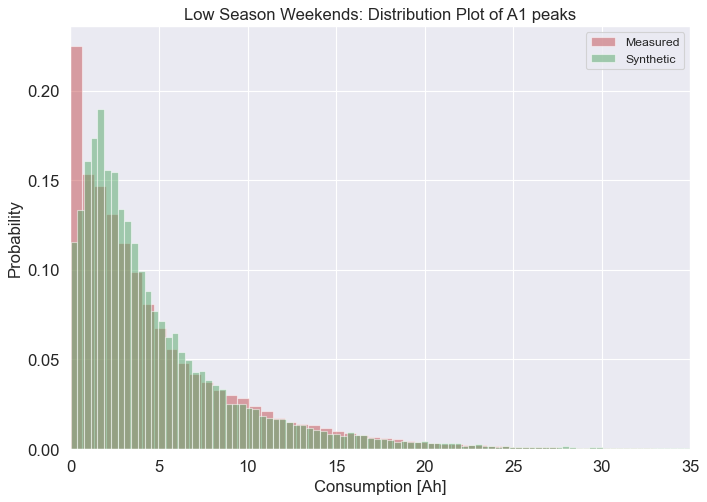

In [26]:
measured_peaks_filtered = temporary.loc[temporary.index.isin(synthetic_peaks_filtered_temp.ProfileID.unique()),:]
# synthetic_peaks_filtered = inv_data_df.loc[inv_data_df.index.isin(profile_ids_good_fit),:]

act_A1 = measured_peaks_filtered['A1']
# act_A2 = measured_peaks_filtered['A2']
synth_A1 = synthetic_peaks_filtered_temp['A1']
# synth_A2 = synthetic_peaks_filtered['A2']

# Normalize
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(act_A1, **kwargs, color='r', label='Measured')
plt.hist(synth_A1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
# plt.gca().set(title='High Season Weekdays: Distribution Plot of A1 peaks', ylabel='Probability')
# plt.xlabel('Consumption [Ah]')
# plt.rcParams.update({'font.size': 15})
plt.title('Low Season Weekends: Distribution Plot of A1 peaks', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Consumption [Ah]', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.legend(fontsize = 30)
plt.xlim(0,35)
plt.legend();

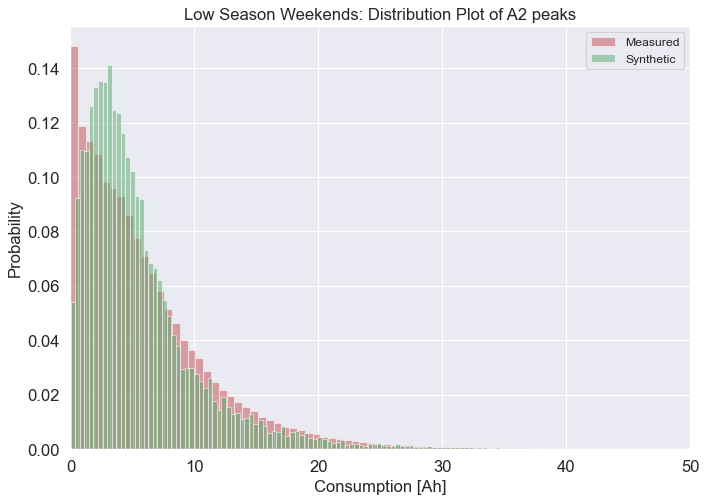

In [27]:
# act_A1 = measured_peaks_filtered['A1']
act_A2 = measured_peaks_filtered['A2']
# synth_A1 = synthetic_peaks_filtered['A1']
synth_A2 = synthetic_peaks_filtered_temp['A2']

# Normalize
kwargs1 = dict(alpha=0.5, bins=100, density=True, stacked=True)
kwargs2 = dict(alpha=0.5, bins=100, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(act_A2, **kwargs1, color='r', label='Measured')
plt.hist(synth_A2, **kwargs2, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
# plt.gca().set(title='Low Season Weekdays: Distribution Plot of A2 peaks', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.title('Low Season Weekends: Distribution Plot of A2 peaks', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Consumption [Ah]', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.legend(fontsize = 'x-large', title_fontsize = 15)
# plt.rcParams.update({'font.size': 50})
plt.xlim(0,50)
plt.legend();

In [29]:
daily_energy_synth = synthetic_df.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

# IQR
Q1 = np.percentile(daily_energy_synth['Daily Energy'], 0,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(daily_energy_synth['Daily Energy'], 90,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", daily_energy_synth.shape)
 
# Upper bound
upper = np.where(daily_energy_synth['Daily Energy'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(daily_energy_synth['Daily Energy'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
daily_energy_synth.drop(upper[0], inplace = True)
daily_energy_synth.drop(lower[0], inplace = True)
 
print("New Shape: ", daily_energy_synth.shape)

NameError: name 'synthetic_df' is not defined

In [28]:
x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=250, density=True, stacked=True)

# Plot
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='Low Season Weekends: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.xlim(0,400)
plt.legend();

NameError: name 'daily_energy_synth_filtered' is not defined

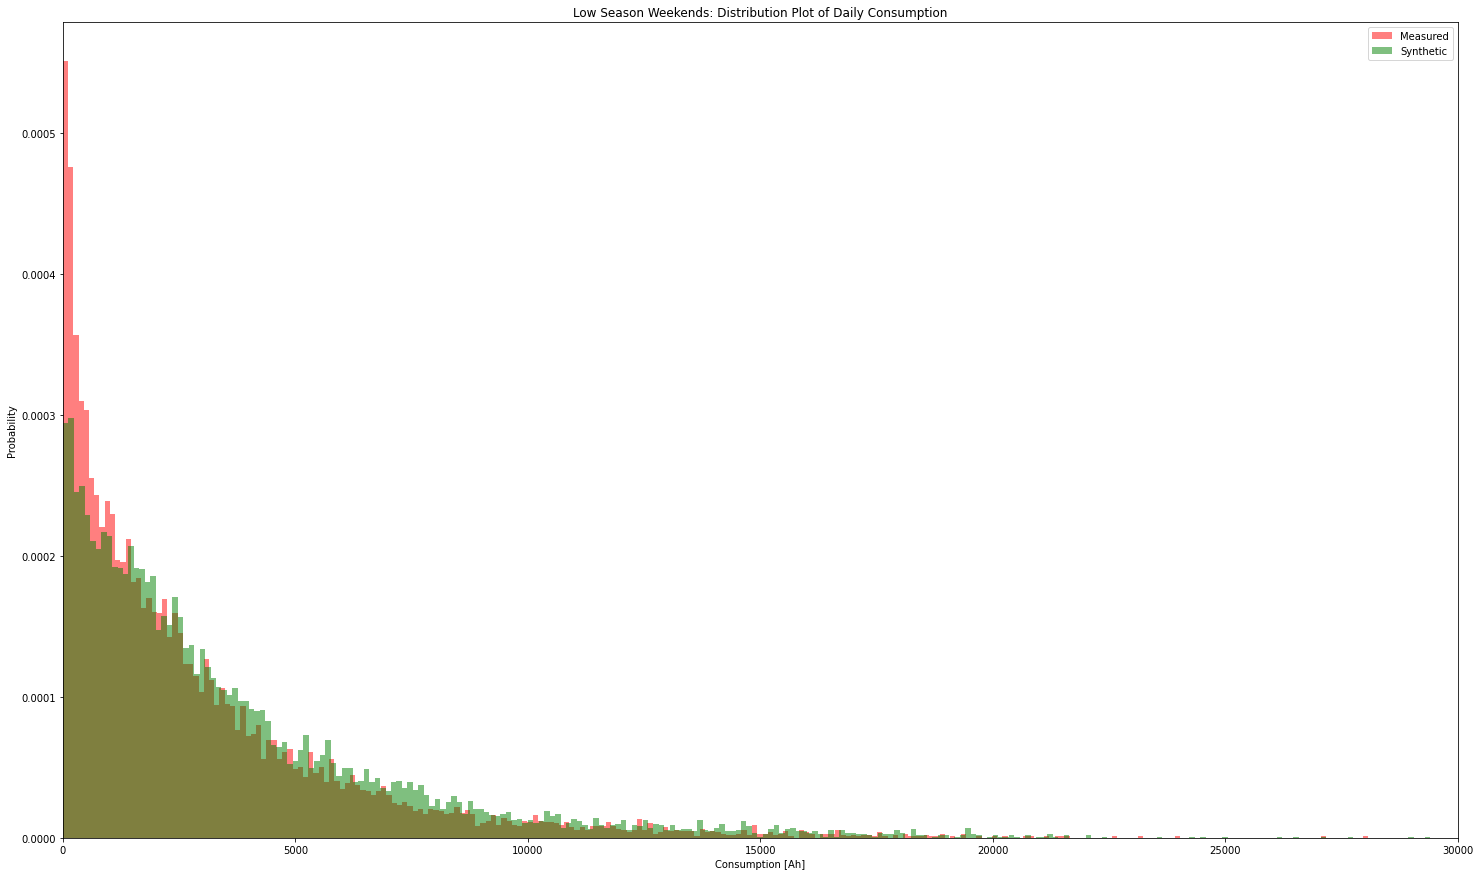

In [220]:
x1 = daily_energy_synth_filtered.groupby(['ProfileID'])['Daily Energy'].sum()#*230/1000
x2 = daily_energy_actual_filtered.groupby(['ProfileID'])['Daily Energy'].sum()#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=250, density=True, stacked=True)

# Plot
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='Low Season Weekends: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.xlim(0,30000)
plt.legend();

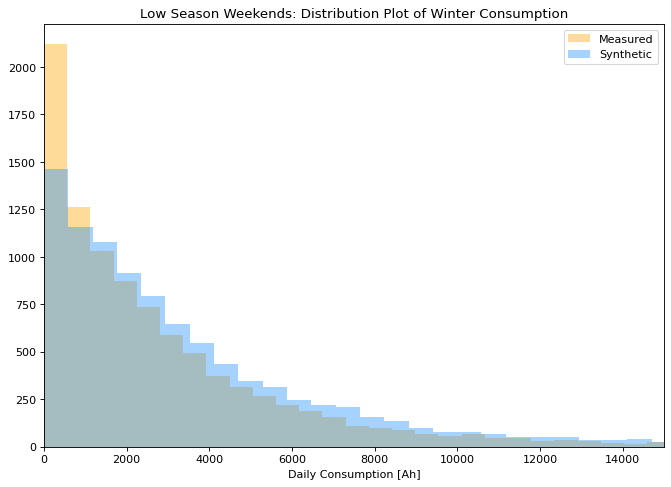

In [188]:
x1 = daily_energy_synth_filtered.groupby(['ProfileID'])['Daily Energy'].sum()#*230/1000
x2 = daily_energy_actual_filtered.groupby(['ProfileID'])['Daily Energy'].sum()#*230/1000

# Plot
kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x2.values, color="orange", label="Measured", **kwargs,kde = False)
sns.distplot(x1.values, color="dodgerblue", label="Synthetic", **kwargs,kde = False)

# sns.distplot(x3, color="deeppink", label="minivan", **kwargs)
plt.title("Low Season Weekends: Distribution Plot of Winter Consumption")
plt.xlabel("Daily Consumption [Ah]")
plt.xlim(0,15000)
plt.legend()

Text(0, 0.5, 'Error [Ah]')

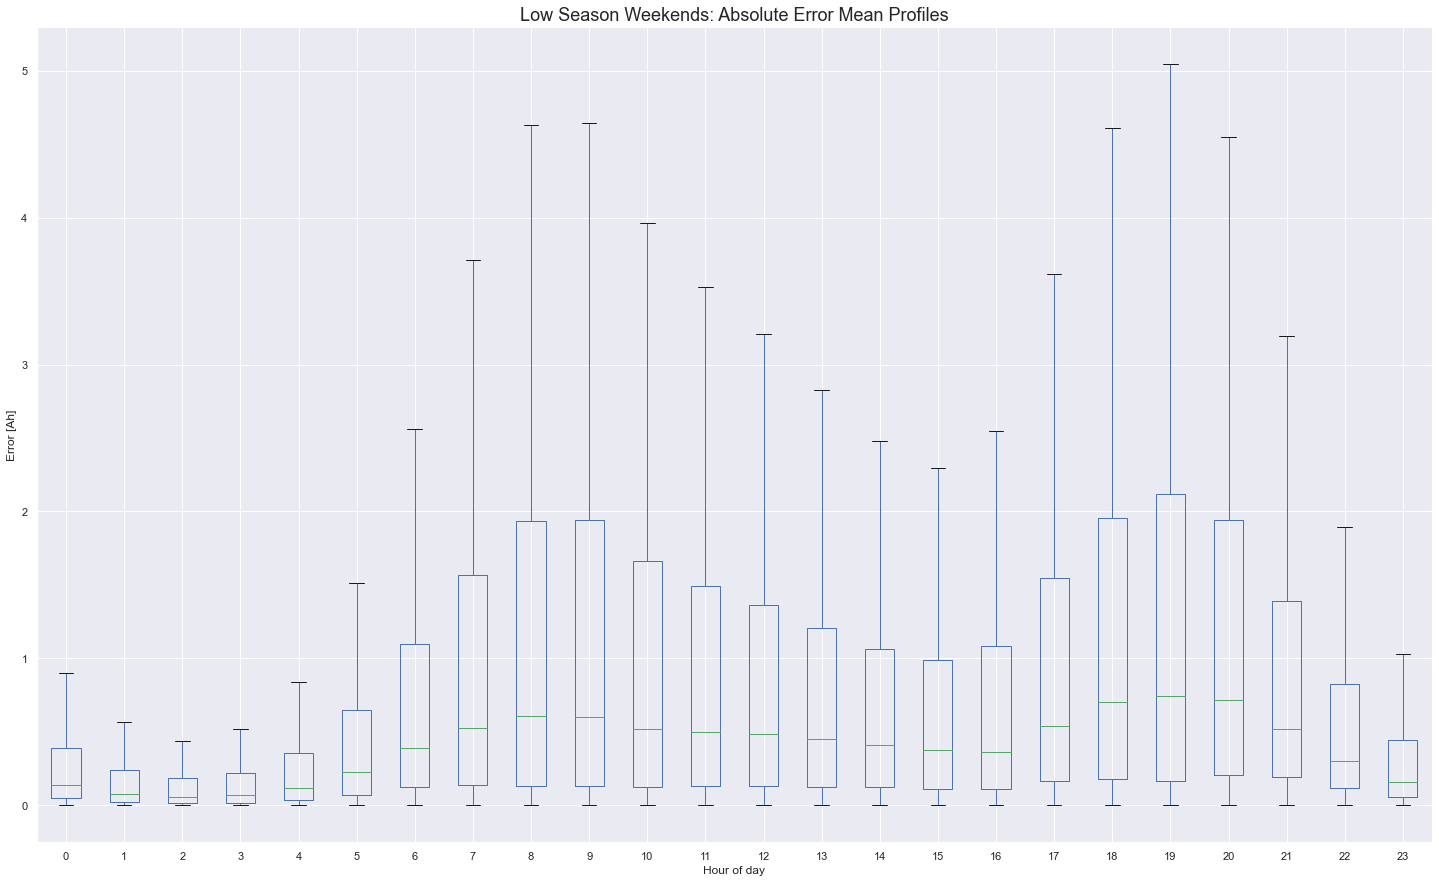

In [56]:
cleaned_df_mean = cleaned_df.groupby(['ProfileID']).mean()
cleaned_df_mean = cleaned_df_mean.sort_index()
cleaned_df_mean.head()

synthetic_df_temp = synthetic_df.reset_index()
synthetic_df_mean = synthetic_df_temp.groupby(['ProfileID']).mean()
synthetic_df_mean.drop(synthetic_df_mean.columns[[-1]], axis = 1, inplace = True)
synthetic_df_mean = synthetic_df_mean.sort_index()
synthetic_df_mean.head()

cleaned_df_mean.columns = synthetic_df_mean.columns
clean_sub_synth_mean = cleaned_df_mean.subtract(synthetic_df_mean)

abs_clean_sub_synth_mean = np.abs(clean_sub_synth_mean)
abs_clean_sub_synth_mean = abs_clean_sub_synth_mean#*230/1000

abs_clean_sub_synth_mean.plot(kind = 'box', showfliers = False)
plt.rcParams['figure.figsize'] = [40,25]
plt.title("Low Season Weekends: Absolute Error Mean Profiles", fontsize = 'large')
plt.xlabel("Hour of day")
plt.ylabel("Error [Ah]")

Text(0, 0.5, 'Error [%]')

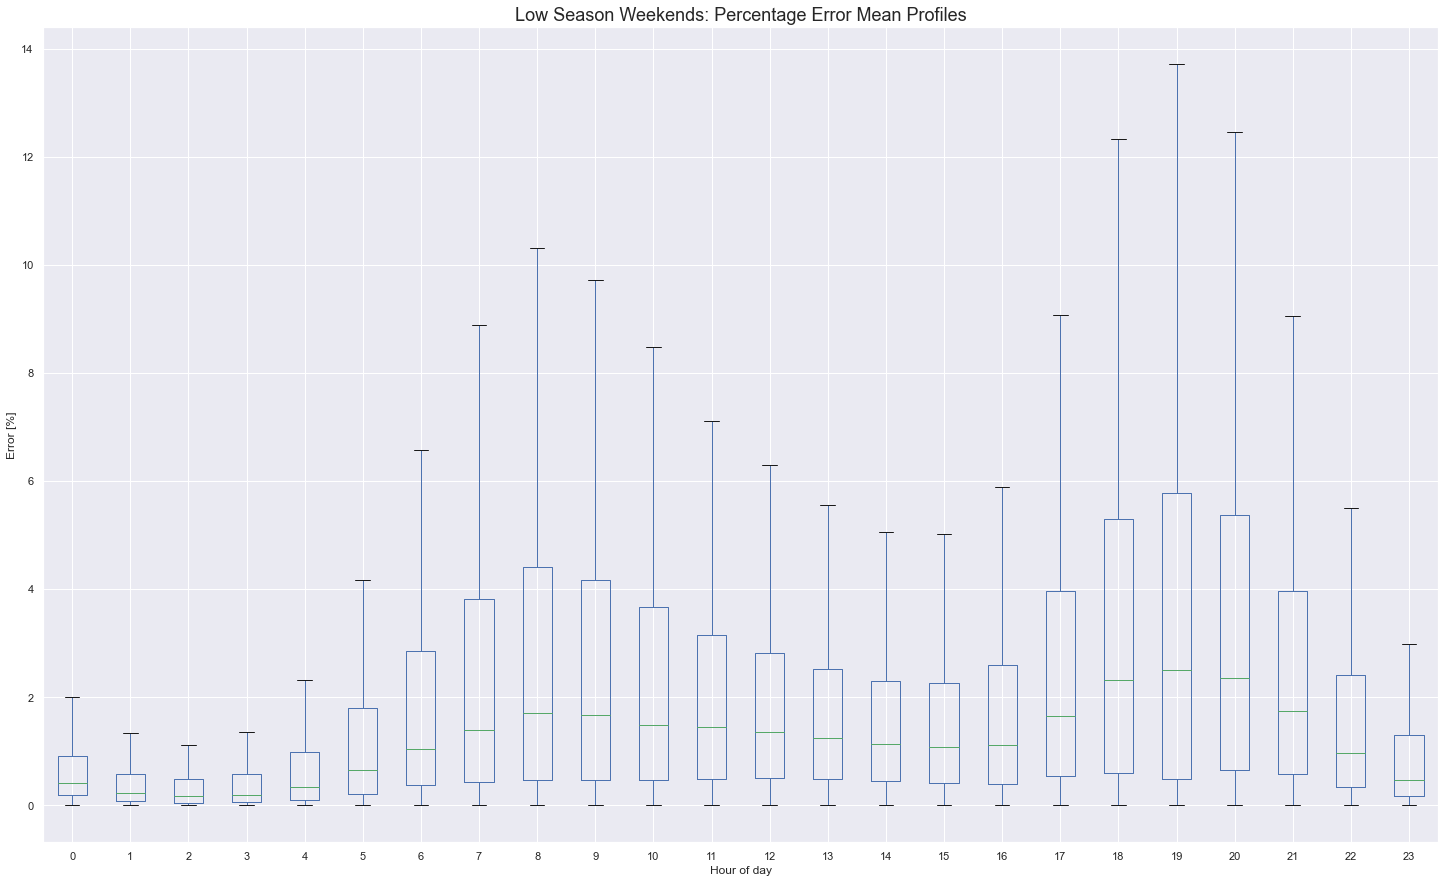

In [55]:
mean_daily_energy_sum = pd.DataFrame(cleaned_df_mean.sum(axis = 1))#*230/1000)
mean_daily_energy_sum.columns

percentage_error = abs_clean_sub_synth_mean.div(mean_daily_energy_sum.values)*100

percentage_error.plot(kind = 'box', showfliers = False)
plt.rcParams['figure.figsize'] = [25,15]
plt.title("Low Season Weekends: Percentage Error Mean Profiles", fontsize = 'large')
plt.xlabel("Hour of day")
plt.ylabel("Error [%]")

In [181]:
mean_daily_energy_sum

,0
ProfileID,
1,10.645115
3,27.654048
5,24.665823
6,17.671903
10,17.464967
...,...
12029045,64.573267
12029049,3.341900
12029058,97.135133


# Evaluate the grid

In [4]:
# Load in the measured data
measured_data = pd.read_csv("Measured_Profiles_Missing_days_replaced_sorted_lenient.csv")
measured_data['date'] = pd.to_datetime(measured_data['date'])
measured_data['date'] = measured_data['date'].apply(lambda x: x.date())
measured_data.set_index(['ProfileID', 'date'], inplace = True)
# measured_data.drop(['ProfileID.1'], axis = 1, inplace = True)
measured_data.reset_index(inplace = True)
measured_data['date'] = measured_data['date'].mask(measured_data['date'].dt.year == 2216, 
                             measured_data['date'] + pd.offsets.DateOffset(year=2016))

In [6]:
synthetic_data = pd.read_csv("CSV_Exclude/Synthetic_Profiles_with_Dates.csv")
synthetic_data['date'] = pd.to_datetime(measured_data['date'])
synthetic_data['date'] = synthetic_data['date'].mask(synthetic_data['date'].dt.year == 2216, 
                             synthetic_data['date'] + pd.offsets.DateOffset(year=2016))

In [34]:
# cols = ['0','1','2']

x1 = measured_data.sum(axis = 1)#*230/1000
x2 = synthetic_data.sum(axis = 1)#*230/1000

In [57]:
x1 = measured_data.drop(['ProfileID'], axis = 1)
x2 = synthetic_data.drop(['ProfileID'], axis = 1)

from scipy import stats

# def remove_outliers(spotmarket,col):
#     r = spotmarket[col].pct_change() * 100

#     Q1 = r.quantile(.25)
#     Q3 = r.quantile(.95)
#     q1 = Q1-1.5*(Q3-Q1)
#     q3 = Q3+1.5*(Q3-Q1)

#     df = spotmarket[r.between(q1, q3)]

#     return df

# x2 = synthetic_data.copy()

# for col in synthetic_data.columns:
#     # print(col)
#     x2 = remove_outliers(x1,col)

# x2.drop(['ProfileID'], axis = 1, inplace = True)

x1 = x1.groupby(['date']).sum()
x2 = x2.groupby(['date']).sum()

x1_aggregate = x1.sum(axis = 1)
x2_aggregate = x2.sum(axis = 1)



NameError: name 'measured_data' is not defined

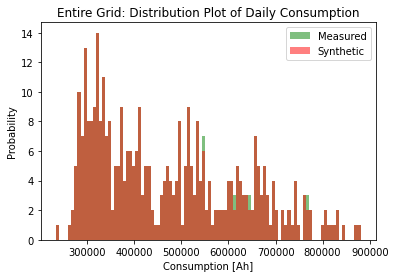

In [113]:
# Normalize
kwargs = dict(alpha=0.5, bins=100, density=False, stacked=True)

# Plot
plt.hist(x1_aggregate.values, **kwargs, color='g', label='Measured')
plt.hist(x2_aggregate.values, **kwargs, color='r', label='Synthetic')

# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='Entire Grid: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
# plt.xlim(0,1)
plt.legend()

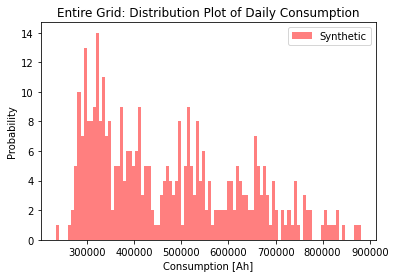

In [111]:
# Normalize
kwargs = dict(alpha=0.5, bins=100, density=False, stacked=True)

# Plot
# plt.hist(x1_aggregate.values, **kwargs, color='g', label='Measured')
plt.hist(x2_aggregate.values, **kwargs, color='r', label='Synthetic')

# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='Entire Grid: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
# plt.xlim(0,1)
plt.legend()

# Boxplots

In [22]:
measured_peaks_filtered = temporary.loc[temporary.index.isin(synthetic_peaks_filtered.ProfileID.unique()),:]

act_A1 = measured_peaks_filtered['A1']
act_A2 = measured_peaks_filtered['A2']
synth_A1 = synthetic_peaks_filtered_temp['A1']
synth_A2 = synthetic_peaks_filtered_temp['A2']

In [23]:
# act_A1_percentiles = np.percentile(act_A1, [25, 50, 75])
# act_A2_percentiles = np.percentile(act_A2, [25, 50, 75])
# synth_A1_percentiles = np.percentile(synth_A1, [25, 50, 75])
# synth_A2_percentiles = np.percentile(synth_A2, [25, 50, 75])

# # MSE = mean_squared_error(actual, predicted)
# # RMSE = math.sqrt(MSE)
# # sMAPE = smape(actual, predicted)

# A1_25_RMSE = np.abs(act_A1_percentiles[0] - synth_A1_percentiles[0])/act_A1_percentiles[0]*100
# A1_50_RMSE = np.abs(act_A1_percentiles[1] - synth_A1_percentiles[1])/act_A1_percentiles[1]*100
# A1_75_RMSE = np.abs(act_A1_percentiles[2] - synth_A1_percentiles[2])/act_A1_percentiles[2]*100
# A2_25_RMSE = np.abs(act_A2_percentiles[0] - synth_A2_percentiles[0])/act_A2_percentiles[0]*100
# A2_50_RMSE = np.abs(act_A2_percentiles[1] - synth_A2_percentiles[1])/act_A2_percentiles[1]*100
# A2_75_RMSE = np.abs(act_A2_percentiles[2] - synth_A2_percentiles[2])/act_A2_percentiles[2]*100

# Percentiles A1
act_A1_25th = measured_peaks_filtered.describe().loc['25%']['A1']
act_A1_50th = measured_peaks_filtered.describe().loc['50%']['A1']
act_A1_75th = measured_peaks_filtered.describe().loc['75%']['A1']

synth_A1_25th = synthetic_peaks_filtered_temp.describe().loc['25%']['A1']
synth_A1_50th = synthetic_peaks_filtered_temp.describe().loc['50%']['A1']
synth_A1_75th = synthetic_peaks_filtered_temp.describe().loc['75%']['A1']

# Percentiles A2
act_A2_25th = measured_peaks_filtered.describe().loc['25%']['A2']
act_A2_50th = measured_peaks_filtered.describe().loc['50%']['A2']
act_A2_75th = measured_peaks_filtered.describe().loc['75%']['A2']

synth_A2_25th = synthetic_peaks_filtered_temp.describe().loc['25%']['A2']
synth_A2_50th = synthetic_peaks_filtered_temp.describe().loc['50%']['A2']
synth_A2_75th = synthetic_peaks_filtered_temp.describe().loc['75%']['A2']

# Percentage Error A1
A1_25_RMSE = np.abs(act_A1_25th - synth_A1_25th)/act_A1_25th*100
A1_50_RMSE = np.abs(act_A1_50th - synth_A1_50th)/act_A1_50th*100
A1_75_RMSE = np.abs(act_A1_75th - synth_A1_75th)/act_A1_75th*100

# Percentage Error A2
A2_25_RMSE = np.abs(act_A2_25th - synth_A2_25th)/act_A2_25th*100
A2_50_RMSE = np.abs(act_A2_50th - synth_A2_50th)/act_A2_50th*100
A2_75_RMSE = np.abs(act_A2_75th - synth_A2_75th)/act_A2_75th*100

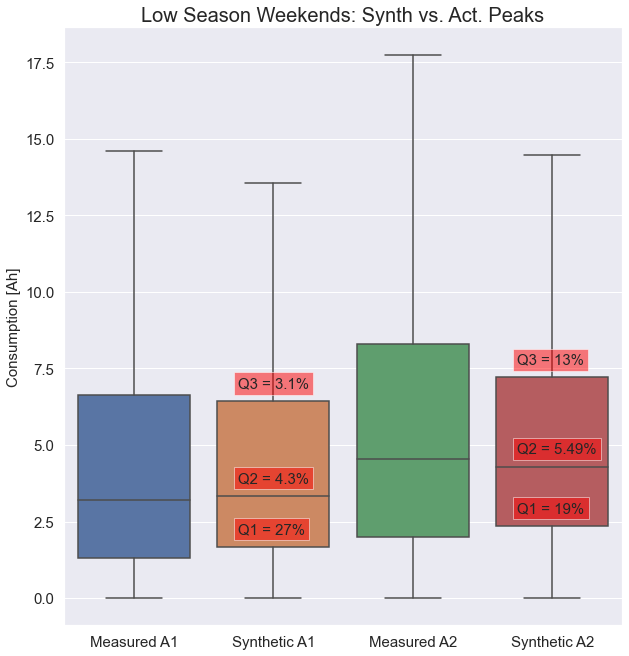

In [25]:
act_A1 = measured_peaks_filtered['A1']#*230/1000
act_A2 = measured_peaks_filtered['A2']#*230/1000
synth_A1 = synthetic_peaks_filtered_temp['A1']#*230/1000
synth_A2 = synthetic_peaks_filtered_temp['A2']#*230/1000

data_to_plot = [act_A1,synth_A1,act_A2,synth_A2]
# sns.set(font_scale=2)
ax = sns.boxplot(data=data_to_plot, showfliers = False)


q1_A1 = synth_A1.quantile(0.25) + 0.45
q2_A1 = synth_A1.quantile(0.5) + 0.45
q3_A1 = synth_A1.quantile(0.75) + 0.45

q1_A2 = synth_A2.quantile(0.25) + 0.45
q2_A2 = synth_A2.quantile(0.5) + 0.45
q3_A2 = synth_A2.quantile(0.75) + 0.45
# Box 1
# 25th Percentile
plt.text(0.75, q1_A1,
         'Q1 = ' + str('{0:.2g}').format(A1_25_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# 50th Percentile
plt.text(0.75, q2_A1,
         'Q2 = ' + str('{0:.2g}').format(A1_50_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# 75th Percentile
plt.text(0.75, q3_A1,
         'Q3 = ' + str('{0:.2g}').format(A1_75_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# Box 3
# 25th Percentile
plt.text(2.75, q1_A2,
         'Q1 = ' + str('{0:.3g}').format(A2_25_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# 50th Percentile
plt.text(2.75, q2_A2,
         'Q2 = ' + str('{0:.3g}').format(A2_50_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# 75th Percentile
plt.text(2.75, q3_A2,
         'Q3 = ' + str('{0:.2g}').format(A2_75_RMSE) + '%',
         bbox=dict(facecolor='red',
         alpha=0.5),
         fontsize='medium')


 
# plt.text(95,1,
#          'Points beyond beyond 75% value',
#          bbox=dict(facecolor='pink',
#                    alpha=0.5),
#          horizontalalignment='right',
#          fontsize='small')

sns.set(rc={"figure.figsize":(10, 11)}) #width=3, #height=4
plt.title("Low Season Weekends: Synth vs. Act. Peaks",fontsize = 20)
plt.ylabel('Consumption [Ah]',fontsize = 15)
plt.xticks([0,1,2,3],['Measured A1', 'Synthetic A1','Measured A2', 'Synthetic A2'],fontsize = 15)
plt.yticks(fontsize = 15)
# plt.legend(title='Legend', loc='upper left', labels=['Measured A1', 'Synthetic A1','Measured A2', 'Synthetic A2'])
plt.rcParams.update({'font.size': 15})
# plt.legend(labels = ['Synthetic A1', 'Measured A1','Synthetic A2', 'Measured A2'], fontsize = 'medium')

# QQ Plot

In [18]:
measured_peaks_filtered = temporary.loc[temporary.index.isin(synthetic_peaks_filtered_temp.ProfileID.unique()),:]
synthetic_peaks_filtered = inv_data_df#.loc[inv_data_df.index.isin(profile_ids_good_fit),:]

act_A1 = measured_peaks_filtered['A1']
act_A2 = measured_peaks_filtered['A2']
synth_A1 = synthetic_peaks_filtered_temp['A1']
synth_A2 = synthetic_peaks_filtered['A2']

def standarise(df,pct,pct_lower):    
    sc = StandardScaler() 
    y = df.values
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

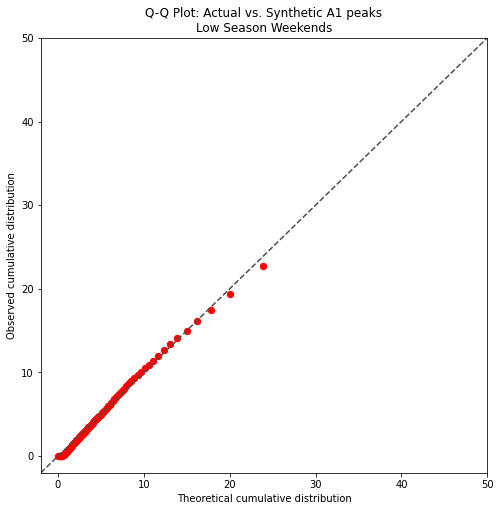

In [19]:
y_std,len_y,y = standarise(synth_A1,0.99,0.01)

y_std = y

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 50], [-2, 50], ls="--", c=".3")

percentile_bins = np.linspace(0,100,100)
percentile_cutoffs1 = np.percentile(synth_A1, percentile_bins)

percentile_cutoffs = np.percentile(act_A1, percentile_bins)

ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',s = 40)
ax.set_title('Q-Q Plot: Actual vs. Synthetic A1 peaks\nLow Season Weekends') 
ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
# ax.legend()
ax.set_ylim(-2,50)
ax.set_xlim(-2,50)
plt.show()

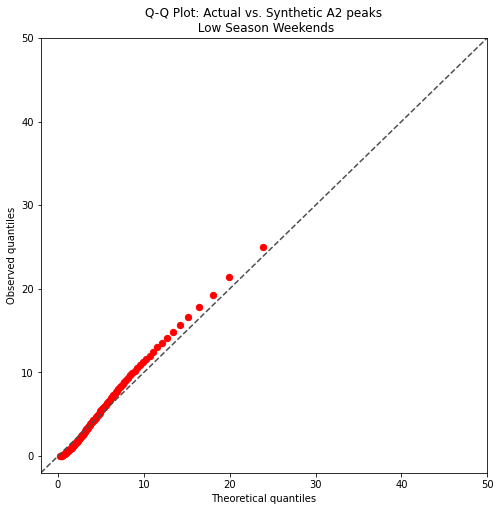

In [20]:
y_std,len_y,y = standarise(synth_A2,0.99,0.01)

y_std = y

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 50], [-2, 50], ls="--", c=".3")

percentile_bins = np.linspace(0,100,100)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)

percentile_cutoffs = np.percentile(act_A2, percentile_bins)

ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',s = 40)
ax.set_title('Q-Q Plot: Actual vs. Synthetic A2 peaks\n Low Season Weekends') 
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Observed quantiles')
# ax.legend()
ax.set_ylim(-2,50)
ax.set_xlim(-2,50)
plt.show()